# Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# disable tensorflow log level infos
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # show only errors

import sys
import pandas as pd

if '..' not in sys.path:
    sys.path.insert(0, '..')

from src.m_utils import constants as cts
from src.base.data_loaders.data_loader import DLName
from src.base.gt_loaders.gt_names import GTName
from src.exp_runner import ExperimentRunner
from src.base.experiment.benchmark_dataset import BenchmarkDataset
from src.base.experiment.model_evaluator import DataSource, DataPredSelection
from src.base.experiment.base_models import BaseModel
from src.base.experiment.optimizers import Optimizer
from src.m_utils.mtl_approach import MTLApproach
from src.m_utils.nas_mtl_approach import NAS_MTLApproach
from src.m_utils.constants import ICAO_REQ, MNIST_TASK

 ==> Restrict GPU memory growth: True


# Start Network runner

In [3]:
kwargs = { 
    'use_neptune': True,
    'exp_params' : {
        'name': 'neural_arch_search',
        'description': 'NAS Approach 2 with FVC dataset with 50 trials and patience and 1 child epoch',
        'tags': ['nas', 'nas_approach_1', 'benchamark', 'mnist', '1_child_epochs'],
        'src_files': ["../src/**/*.py"]
    },
    'properties': {
        'approach': NAS_MTLApproach.APPROACH_2,
        'benchmarking': {
            'use_benchmark_data': False,
            'benchmark_dataset': BenchmarkDataset.MNIST,
            'tasks': list(MNIST_TASK)
        },
        'icao_data': {
            'icao_gt': {
                'use_gt_data': True,
                'gt_names': {
                    'train_validation': [],
                    'test': [],
                    'train_validation_test': [GTName.FVC]
                },
            },
            'icao_dl': {
                'use_dl_data': False,
                'tagger_model': None
            },
            'reqs': list(ICAO_REQ),
            'aligned': False
        },
        'balance_input_data': False,
        'train_model': True,
        'save_trained_model': True,
        'exec_nas': True,
        'orig_model_experiment_id': '',
        'sample_training_data': False,
        'sample_prop': 1.0
    },
    'net_train_params': {
        'base_model': BaseModel.MOBILENET_V2,
        'batch_size': 32,
        'n_epochs': 50,
        'early_stopping': 5,
        'learning_rate': 1e-3,
        'optimizer': Optimizer.ADAMAX,
        'dropout': 0.3
    },
    'nas_params': {
        'max_blocks_per_branch': 5,
        'n_child_epochs': 1,
        'controller_epochs': 50,
        'controller_batch_size': 32,
        'n_trials': 50
    }
}

runner = ExperimentRunner(**kwargs)

-------------------- Init ExperimentRunner -------------------
---------------------------
Parent Process ID: 17689
Process ID: 43390
---------------------------
-----
Use Neptune:  True
-----
-------------------
Args: 
{'exp_params': {'description': 'NAS Approach 2 with FVC dataset with 50 trials '
                               'and patience and 1 child epoch',
                'name': 'neural_arch_search',
                'src_files': ['../**/src/**.py'],
                'tags': ['nas',
                         'nas_approach_1',
                         'benchamark',
                         'mnist',
                         '1_child_epochs']},
 'nas_params': {'controller_batch_size': 32,
                'controller_epochs': 50,
                'max_blocks_per_branch': 5,
                'n_child_epochs': 1,
                'n_trials': 50},
 'net_train_params': {'base_model': <BaseModel.MOBILENET_V2: {'name': 'mobilnet_v2', 'target_size': (224, 224), 'prep_function': <function prepro

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


# Load Data

In [4]:
runner.load_training_data()

-------------------- load training data -------------------
Loading data
Loading GT FVC - TRAIN split...
..Ignoring 0 empty label values
Input data.shape: (4928, 26)
Loading GT FVC - VALIDATION split...
..Ignoring 0 empty label values
Input data.shape: (547, 26)
Loading GT FVC - TEST split...
..Ignoring 0 empty label values
Input data.shape: (288, 26)
Data loaded


In [5]:
runner.train_data.head()

origin                                           img_name  mouth  rotation  \
0    fvc  /home/guilherme/data1/Dropbox/Link to Desktop/...    1.0       1.0   
1    fvc  /home/guilherme/data1/Dropbox/Link to Desktop/...    1.0       1.0   
2    fvc  /home/guilherme/data1/Dropbox/Link to Desktop/...    0.0       1.0   
3    fvc  /home/guilherme/data1/Dropbox/Link to Desktop/...    1.0       1.0   
4    fvc  /home/guilherme/data1/Dropbox/Link to Desktop/...    1.0       1.0   

   l_away  eyes_closed  close  hat  dark_glasses  frames_heavy  ...  sh_head  \
0     1.0          1.0    1.0  1.0           1.0           1.0  ...      0.0   
1     0.0          1.0    1.0  1.0           1.0           1.0  ...      1.0   
2     1.0          1.0    1.0  1.0           1.0           1.0  ...      1.0   
3     1.0          1.0    1.0  1.0           1.0           1.0  ...      0.0   
4     1.0          1.0    1.0  1.0           1.0           1.0  ...      0.0   

   blurred  ink_mark  skin_tone  washed_out  pixelation  hair_eyes  \
0      1.0       1.0        1.0         1.0         1.0        1.0   
1      1.0       1.0        1.0         1.0         1.0        1.0   
2      1.0       1.0        1.0         1.0         1.0        1.0   
3      1.0       1.0        0.0         1.0         1.0        1.0   
4      1.0       1.0        0.0         1.0         1.0        1.0   

   background  red_eyes  aligned  
0         1.0       1.0    False  
1         1.0       1.0    False  
2         1.0       1.0    False  
3         0.0       1.0    False  
4         0.0       1.0    False  

[5 rows x 26 columns]

# <font color='red'>Producing Fake Data</font>

# Data Generators

In [6]:
runner.setup_data_generators()

-------------------- setup data generators -------------------
Starting data generators
Found 4928 validated image filenames.
Found 547 validated image filenames.
Found 288 validated image filenames.
TOTAL: 5763

Logging class indices
 .. MTL model not logging class indices!

Logging class labels
 COMPLIANT label: 1
 NON_COMPLIANT label: 0
 DUMMY label: -1
 DUMMY_CLS label: 2
 NO_ANSWER label: -99


# Setup Experiment

In [7]:
runner.setup_experiment()

-------------------- create experiment -------------------
Setup neptune properties and parameters
Properties and parameters setup done!


# Labels Distribution

In [8]:
%%capture
runner.summary_labels_dist()

# Neural Architecture Search

In [9]:
runner.run_neural_architeture_search()

-------------------- run neural architecture search -------------------
Executing neural architectural search
  Memory reseted

==================== STARTING NEW TRIAL ====================
 selecting new config...
  Memory is empty
 controller_pred: [[0.25662524 0.27733207 0.25776684 0.20827588]]


 ------ Training 1 | Config: {'n_denses_0': 2, 'n_denses_1': 2, 'n_denses_2': 2, 'n_denses_3': 2} -----

Creating model...
Model created
Training MOBILENET_V2 network
 .. Not fine tuning base model...
  .. Total params: 4,242,286
  .. Trainable params: 1,984,302
  .. Non-trainable params: 2,257,984

Epoch 00001: val_loss improved from inf to 2.97096, saving model to training_ckpt/best_model.hdf5


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.29290 | EER_interp: 0.29210 | ACC: 0.70750
  Task  1: rotation        | EER_mean: 0.32440 | EER_interp: 0.32280 | ACC: 0.67640
  Task  2: l_away          | EER_mean: 0.24850 | EER_interp: 0.24990 | ACC: 0.74950
  Task  3: eyes_closed     | EER_mean: 0.11110 | EER_interp: 0.10740 | ACC: 0.89030
  Task  4: close           | EER_mean: 0.50050 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.14290 | EER_interp: 0.14260 | ACC: 0.85560
  Task  6: dark_glasses    | EER_mean: 0.20030 | EER_interp: 0.00000 | ACC: 0.09510
  Task  7: frames_heavy    | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.14430 | EER_interp: 0.14120 | ACC: 0.85740
  Task  9: flash_lenses    | EER_mean: 0.17880 | EER_interp: 0.17840 | ACC: 0.82080
  Task 10: veil            | EER_mean: 0.44070 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.26600 | EER_interp: 0.26510 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.22620 | EER_interp: 0.22340 | ACC: 0.77510
  Task  1: rotation        | EER_mean: 0.29200 | EER_interp: 0.29110 | ACC: 0.70930
  Task  2: l_away          | EER_mean: 0.21820 | EER_interp: 0.22040 | ACC: 0.77880
  Task  3: eyes_closed     | EER_mean: 0.08840 | EER_interp: 0.08660 | ACC: 0.91220
  Task  4: close           | EER_mean: 0.45550 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.40050 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.06070 | EER_interp: 0.05360 | ACC: 0.93420
  Task  7: frames_heavy    | EER_mean: 0.50460 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.15700 | EER_interp: 0.15420 | ACC: 0.84460
  Task  9: flash_lenses    | EER_mean: 0.11500 | EER_interp: 0.11400 | ACC: 0.88670
  Task 10: veil            | EER_mean: 0.08330 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.24470 | EER_interp: 0.24500 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.29800 | EER_interp: 0.29560 | ACC: 0.70200
  Task  1: rotation        | EER_mean: 0.29020 | EER_interp: 0.28740 | ACC: 0.71120
  Task  2: l_away          | EER_mean: 0.20420 | EER_interp: 0.20210 | ACC: 0.79710
  Task  3: eyes_closed     | EER_mean: 0.07480 | EER_interp: 0.07520 | ACC: 0.92500
  Task  4: close           | EER_mean: 0.46290 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.28960 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.08900 | EER_interp: 0.00000 | ACC: 0.09510
  Task  7: frames_heavy    | EER_mean: 0.50090 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.13160 | EER_interp: 0.12780 | ACC: 0.87390
  Task  9: flash_lenses    | EER_mean: 0.24420 | EER_interp: 0.24160 | ACC: 0.75690
  Task 10: veil            | EER_mean: 0.27050 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.24110 | EER_interp: 0.24130 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.26770 | EER_interp: 0.25410 | ACC: 0.75320
  Task  1: rotation        | EER_mean: 0.35370 | EER_interp: 0.35200 | ACC: 0.64720
  Task  2: l_away          | EER_mean: 0.20610 | EER_interp: 0.20640 | ACC: 0.79340
  Task  3: eyes_closed     | EER_mean: 0.08160 | EER_interp: 0.07860 | ACC: 0.91960
  Task  4: close           | EER_mean: 0.20710 | EER_interp: 0.00000 | ACC: 0.75320
  Task  5: hat             | EER_mean: 0.11830 | EER_interp: 0.11860 | ACC: 0.88120
  Task  6: dark_glasses    | EER_mean: 0.04650 | EER_interp: 0.04250 | ACC: 0.95430
  Task  7: frames_heavy    | EER_mean: 0.14060 | EER_interp: 0.00000 | ACC: 0.83550
  Task  8: frame_eyes      | EER_mean: 0.14680 | EER_interp: 0.14580 | ACC: 0.85370
  Task  9: flash_lenses    | EER_mean: 0.27190 | EER_interp: 0.26870 | ACC: 0.72940
  Task 10: veil            | EER_mean: 0.04080 | EER_interp: 0.03660 | ACC: 0.95800
  Task 11: reflection      | EER_mean: 0.28680 | EER_interp: 0.28700 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.26770 | EER_interp: 0.27200 | ACC: 0.72580
  Task  1: rotation        | EER_mean: 0.40240 | EER_interp: 0.40200 | ACC: 0.59780
  Task  2: l_away          | EER_mean: 0.21820 | EER_interp: 0.21640 | ACC: 0.78430
  Task  3: eyes_closed     | EER_mean: 0.10640 | EER_interp: 0.10630 | ACC: 0.89210
  Task  4: close           | EER_mean: 0.50050 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.18790 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.08800 | EER_interp: 0.00000 | ACC: 0.09510
  Task  7: frames_heavy    | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.17800 | EER_interp: 0.17920 | ACC: 0.81720
  Task  9: flash_lenses    | EER_mean: 0.26170 | EER_interp: 0.00000 | ACC: 0.20660
  Task 10: veil            | EER_mean: 0.10890 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.24470 | EER_interp: 0.24310 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.29130 | EER_interp: 0.29090 | ACC: 0.70930
  Task  1: rotation        | EER_mean: 0.37230 | EER_interp: 0.37280 | ACC: 0.62710
  Task  2: l_away          | EER_mean: 0.26670 | EER_interp: 0.27080 | ACC: 0.72760
  Task  3: eyes_closed     | EER_mean: 0.10790 | EER_interp: 0.10630 | ACC: 0.89210
  Task  4: close           | EER_mean: 0.50190 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.33690 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.16210 | EER_interp: 0.00000 | ACC: 0.09510
  Task  7: frames_heavy    | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.18350 | EER_interp: 0.18600 | ACC: 0.81900
  Task  9: flash_lenses    | EER_mean: 0.17510 | EER_interp: 0.17600 | ACC: 0.82450
  Task 10: veil            | EER_mean: 0.38890 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.29430 | EER_interp: 0.29250 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.25710 | EER_interp: 0.25460 | ACC: 0.74410
  Task  1: rotation        | EER_mean: 0.29760 | EER_interp: 0.29480 | ACC: 0.70380
  Task  2: l_away          | EER_mean: 0.20000 | EER_interp: 0.19820 | ACC: 0.80260
  Task  3: eyes_closed     | EER_mean: 0.07550 | EER_interp: 0.07740 | ACC: 0.92140
  Task  4: close           | EER_mean: 0.16670 | EER_interp: 0.19980 | ACC: 0.76780
  Task  5: hat             | EER_mean: 0.10750 | EER_interp: 0.10990 | ACC: 0.88850
  Task  6: dark_glasses    | EER_mean: 0.01920 | EER_interp: 0.01660 | ACC: 0.98540
  Task  7: frames_heavy    | EER_mean: 0.41130 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.14470 | EER_interp: 0.14450 | ACC: 0.85560
  Task  9: flash_lenses    | EER_mean: 0.22120 | EER_interp: 0.22350 | ACC: 0.77510
  Task 10: veil            | EER_mean: 0.08350 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.29790 | EER_interp: 0.29610 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.29920 | EER_interp: 0.30320 | ACC: 0.69470
  Task  1: rotation        | EER_mean: 0.26830 | EER_interp: 0.26550 | ACC: 0.73310
  Task  2: l_away          | EER_mean: 0.19390 | EER_interp: 0.19250 | ACC: 0.80800
  Task  3: eyes_closed     | EER_mean: 0.09070 | EER_interp: 0.08780 | ACC: 0.91040
  Task  4: close           | EER_mean: 0.45870 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.10170 | EER_interp: 0.10130 | ACC: 0.89580
  Task  6: dark_glasses    | EER_mean: 0.08820 | EER_interp: 0.00000 | ACC: 0.09510
  Task  7: frames_heavy    | EER_mean: 0.50650 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.16200 | EER_interp: 0.16000 | ACC: 0.83910
  Task  9: flash_lenses    | EER_mean: 0.24780 | EER_interp: 0.25060 | ACC: 0.74770
  Task 10: veil            | EER_mean: 0.45050 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.29080 | EER_interp: 0.29070 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.22830 | EER_interp: 0.22600 | ACC: 0.77510
  Task  1: rotation        | EER_mean: 0.29510 | EER_interp: 0.29360 | ACC: 0.70570
  Task  2: l_away          | EER_mean: 0.26060 | EER_interp: 0.26510 | ACC: 0.73310
  Task  3: eyes_closed     | EER_mean: 0.14010 | EER_interp: 0.14240 | ACC: 0.86290
  Task  4: close           | EER_mean: 0.45820 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.19390 | EER_interp: 0.19160 | ACC: 0.80260
  Task  6: dark_glasses    | EER_mean: 0.42220 | EER_interp: 0.00000 | ACC: 0.09510
  Task  7: frames_heavy    | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.13420 | EER_interp: 0.13290 | ACC: 0.86650
  Task  9: flash_lenses    | EER_mean: 0.11750 | EER_interp: 0.11620 | ACC: 0.88300
  Task 10: veil            | EER_mean: 0.08350 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.28680 | EER_interp: 0.28700 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.28350 | EER_interp: 0.28340 | ACC: 0.71660
  Task  1: rotation        | EER_mean: 0.28470 | EER_interp: 0.28870 | ACC: 0.70930
  Task  2: l_away          | EER_mean: 0.19110 | EER_interp: 0.18950 | ACC: 0.80990
  Task  3: eyes_closed     | EER_mean: 0.10380 | EER_interp: 0.10180 | ACC: 0.89950
  Task  4: close           | EER_mean: 0.45640 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.16090 | EER_interp: 0.16100 | ACC: 0.83910
  Task  6: dark_glasses    | EER_mean: 0.27820 | EER_interp: 0.00000 | ACC: 0.09510
  Task  7: frames_heavy    | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.12410 | EER_interp: 0.12120 | ACC: 0.87750
  Task  9: flash_lenses    | EER_mean: 0.17430 | EER_interp: 0.00000 | ACC: 0.20660
  Task 10: veil            | EER_mean: 0.45000 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.20380 | EER_interp: 0.20300 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.18330 | EER_interp: 0.18220 | ACC: 0.81720
  Task  1: rotation        | EER_mean: 0.30660 | EER_interp: 0.30570 | ACC: 0.69470
  Task  2: l_away          | EER_mean: 0.22250 | EER_interp: 0.22340 | ACC: 0.77700
  Task  3: eyes_closed     | EER_mean: 0.11320 | EER_interp: 0.12010 | ACC: 0.87570
  Task  4: close           | EER_mean: 0.45730 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.09790 | EER_interp: 0.10240 | ACC: 0.88670
  Task  6: dark_glasses    | EER_mean: 0.02020 | EER_interp: 0.01970 | ACC: 0.97990
  Task  7: frames_heavy    | EER_mean: 0.50050 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.18480 | EER_interp: 0.18450 | ACC: 0.81540
  Task  9: flash_lenses    | EER_mean: 0.30120 | EER_interp: 0.29690 | ACC: 0.70020
  Task 10: veil            | EER_mean: 0.02960 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.26950 | EER_interp: 0.26870 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.27140 | EER_interp: 0.26950 | ACC: 0.72940
  Task  1: rotation        | EER_mean: 0.32680 | EER_interp: 0.32400 | ACC: 0.67460
  Task  2: l_away          | EER_mean: 0.20940 | EER_interp: 0.20780 | ACC: 0.79160
  Task  3: eyes_closed     | EER_mean: 0.08490 | EER_interp: 0.08320 | ACC: 0.91770
  Task  4: close           | EER_mean: 0.15050 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.14470 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.03030 | EER_interp: 0.02480 | ACC: 0.97070
  Task  7: frames_heavy    | EER_mean: 0.10140 | EER_interp: 0.00000 | ACC: 0.89030
  Task  8: frame_eyes      | EER_mean: 0.16450 | EER_interp: 0.16580 | ACC: 0.83360
  Task  9: flash_lenses    | EER_mean: 0.23890 | EER_interp: 0.23350 | ACC: 0.76970
  Task 10: veil            | EER_mean: 0.05920 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.19250 | EER_interp: 0.19200 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.21260 | EER_interp: 0.20160 | ACC: 0.80440
  Task  1: rotation        | EER_mean: 0.32910 | EER_interp: 0.32890 | ACC: 0.67090
  Task  2: l_away          | EER_mean: 0.20610 | EER_interp: 0.20780 | ACC: 0.79160
  Task  3: eyes_closed     | EER_mean: 0.09520 | EER_interp: 0.09480 | ACC: 0.90490
  Task  4: close           | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.23300 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.05530 | EER_interp: 0.00000 | ACC: 0.09510
  Task  7: frames_heavy    | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.18730 | EER_interp: 0.18580 | ACC: 0.81350
  Task  9: flash_lenses    | EER_mean: 0.16810 | EER_interp: 0.16820 | ACC: 0.83180
  Task 10: veil            | EER_mean: 0.29790 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.20750 | EER_interp: 0.20660 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.18900 | EER_interp: 0.18860 | ACC: 0.81170
  Task  1: rotation        | EER_mean: 0.33900 | EER_interp: 0.33740 | ACC: 0.66180
  Task  2: l_away          | EER_mean: 0.19900 | EER_interp: 0.19650 | ACC: 0.80260
  Task  3: eyes_closed     | EER_mean: 0.08160 | EER_interp: 0.07860 | ACC: 0.91960
  Task  4: close           | EER_mean: 0.27270 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.15040 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.02670 | EER_interp: 0.02380 | ACC: 0.97260
  Task  7: frames_heavy    | EER_mean: 0.50650 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.12910 | EER_interp: 0.13040 | ACC: 0.87020
  Task  9: flash_lenses    | EER_mean: 0.15930 | EER_interp: 0.16260 | ACC: 0.83550
  Task 10: veil            | EER_mean: 0.19600 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.22640 | EER_interp: 0.22840 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.22830 | EER_interp: 0.22720 | ACC: 0.77330
  Task  1: rotation        | EER_mean: 0.33170 | EER_interp: 0.33010 | ACC: 0.66910
  Task  2: l_away          | EER_mean: 0.21820 | EER_interp: 0.22690 | ACC: 0.76970
  Task  3: eyes_closed     | EER_mean: 0.06600 | EER_interp: 0.06590 | ACC: 0.93420
  Task  4: close           | EER_mean: 0.50850 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.07530 | EER_interp: 0.07620 | ACC: 0.92320
  Task  6: dark_glasses    | EER_mean: 0.01920 | EER_interp: 0.00000 | ACC: 0.99820
  Task  7: frames_heavy    | EER_mean: 0.10090 | EER_interp: 0.00000 | ACC: 0.89580
  Task  8: frame_eyes      | EER_mean: 0.11900 | EER_interp: 0.11870 | ACC: 0.88120
  Task  9: flash_lenses    | EER_mean: 0.18250 | EER_interp: 0.17620 | ACC: 0.81900
  Task 10: veil            | EER_mean: 0.03030 | EER_interp: 0.02780 | ACC: 0.97440
  Task 11: reflection      | EER_mean: 0.28300 | EER_interp: 0.28340 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.25980 | EER_interp: 0.26090 | ACC: 0.73860
  Task  1: rotation        | EER_mean: 0.35770 | EER_interp: 0.35690 | ACC: 0.64350
  Task  2: l_away          | EER_mean: 0.20000 | EER_interp: 0.20080 | ACC: 0.79890
  Task  3: eyes_closed     | EER_mean: 0.06600 | EER_interp: 0.06820 | ACC: 0.93050
  Task  4: close           | EER_mean: 0.26270 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.15140 | EER_interp: 0.15120 | ACC: 0.84830
  Task  6: dark_glasses    | EER_mean: 0.03840 | EER_interp: 0.02880 | ACC: 0.96340
  Task  7: frames_heavy    | EER_mean: 0.50050 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.16450 | EER_interp: 0.16960 | ACC: 0.82820
  Task  9: flash_lenses    | EER_mean: 0.23010 | EER_interp: 0.23020 | ACC: 0.76970
  Task 10: veil            | EER_mean: 0.03030 | EER_interp: 0.02580 | ACC: 0.97810
  Task 11: reflection      | EER_mean: 0.24150 | EER_interp: 0.23780 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.20470 | EER_interp: 0.20710 | ACC: 0.79160
  Task  1: rotation        | EER_mean: 0.34310 | EER_interp: 0.33980 | ACC: 0.66180
  Task  2: l_away          | EER_mean: 0.20610 | EER_interp: 0.20900 | ACC: 0.78980
  Task  3: eyes_closed     | EER_mean: 0.06600 | EER_interp: 0.06700 | ACC: 0.93240
  Task  4: close           | EER_mean: 0.50050 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.10280 | EER_interp: 0.09910 | ACC: 0.89210
  Task  6: dark_glasses    | EER_mean: 0.01920 | EER_interp: 0.01660 | ACC: 0.98540
  Task  7: frames_heavy    | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.12660 | EER_interp: 0.12580 | ACC: 0.87390
  Task  9: flash_lenses    | EER_mean: 0.21660 | EER_interp: 0.21000 | ACC: 0.78610
  Task 10: veil            | EER_mean: 0.15380 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.24530 | EER_interp: 0.24860 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.26770 | EER_interp: 0.27080 | ACC: 0.72760
  Task  1: rotation        | EER_mean: 0.29930 | EER_interp: 0.30210 | ACC: 0.69650
  Task  2: l_away          | EER_mean: 0.20000 | EER_interp: 0.19690 | ACC: 0.80440
  Task  3: eyes_closed     | EER_mean: 0.09430 | EER_interp: 0.09360 | ACC: 0.90680
  Task  4: close           | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.49180 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.03780 | EER_interp: 0.00000 | ACC: 0.09510
  Task  7: frames_heavy    | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.15130 | EER_interp: 0.15160 | ACC: 0.84830
  Task  9: flash_lenses    | EER_mean: 0.19350 | EER_interp: 0.18960 | ACC: 0.80800
  Task 10: veil            | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.28370 | EER_interp: 0.28340 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.20240 | EER_interp: 0.19960 | ACC: 0.79890
  Task  1: rotation        | EER_mean: 0.28780 | EER_interp: 0.28620 | ACC: 0.71300
  Task  2: l_away          | EER_mean: 0.19390 | EER_interp: 0.19250 | ACC: 0.80800
  Task  3: eyes_closed     | EER_mean: 0.10430 | EER_interp: 0.10400 | ACC: 0.89580
  Task  4: close           | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.18830 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.01920 | EER_interp: 0.02170 | ACC: 0.97620
  Task  7: frames_heavy    | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.13820 | EER_interp: 0.13870 | ACC: 0.86110
  Task  9: flash_lenses    | EER_mean: 0.15930 | EER_interp: 0.15920 | ACC: 0.84100
  Task 10: veil            | EER_mean: 0.38890 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.29810 | EER_interp: 0.29800 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.18900 | EER_interp: 0.18860 | ACC: 0.81170
  Task  1: rotation        | EER_mean: 0.28470 | EER_interp: 0.28510 | ACC: 0.71480
  Task  2: l_away          | EER_mean: 0.22420 | EER_interp: 0.22460 | ACC: 0.77510
  Task  3: eyes_closed     | EER_mean: 0.08160 | EER_interp: 0.08320 | ACC: 0.91770
  Task  4: close           | EER_mean: 0.50370 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.18610 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.03850 | EER_interp: 0.04750 | ACC: 0.94520
  Task  7: frames_heavy    | EER_mean: 0.26080 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.10890 | EER_interp: 0.10710 | ACC: 0.89210
  Task  9: flash_lenses    | EER_mean: 0.13360 | EER_interp: 0.13320 | ACC: 0.86650
  Task 10: veil            | EER_mean: 0.05720 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.29430 | EER_interp: 0.29240 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 33s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.22830 | EER_interp: 0.23800 | ACC: 0.75690
  Task  1: rotation        | EER_mean: 0.32200 | EER_interp: 0.31800 | ACC: 0.68010
  Task  2: l_away          | EER_mean: 0.26960 | EER_interp: 0.27120 | ACC: 0.72940
  Task  3: eyes_closed     | EER_mean: 0.13210 | EER_interp: 0.13520 | ACC: 0.86290
  Task  4: close           | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.29550 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.24680 | EER_interp: 0.00000 | ACC: 0.09510
  Task  7: frames_heavy    | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.15720 | EER_interp: 0.15740 | ACC: 0.84280
  Task  9: flash_lenses    | EER_mean: 0.19630 | EER_interp: 0.19340 | ACC: 0.79710
  Task 10: veil            | EER_mean: 0.40000 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.23400 | EER_interp: 0.23400 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.22140 | EER_interp: 0.22100 | ACC: 0.77880
  Task  1: rotation        | EER_mean: 0.37320 | EER_interp: 0.36540 | ACC: 0.63070
  Task  2: l_away          | EER_mean: 0.21210 | EER_interp: 0.21340 | ACC: 0.78610
  Task  3: eyes_closed     | EER_mean: 0.06120 | EER_interp: 0.06360 | ACC: 0.93780
  Task  4: close           | EER_mean: 0.50190 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.35700 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.03850 | EER_interp: 0.04140 | ACC: 0.95610
  Task  7: frames_heavy    | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.09870 | EER_interp: 0.09870 | ACC: 0.90130
  Task  9: flash_lenses    | EER_mean: 0.15210 | EER_interp: 0.15120 | ACC: 0.84830
  Task 10: veil            | EER_mean: 0.03030 | EER_interp: 0.03850 | ACC: 0.95430
  Task 11: reflection      | EER_mean: 0.26600 | EER_interp: 0.26320 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.23620 | EER_interp: 0.23960 | ACC: 0.75870
  Task  1: rotation        | EER_mean: 0.35850 | EER_interp: 0.35810 | ACC: 0.64170
  Task  2: l_away          | EER_mean: 0.19390 | EER_interp: 0.20040 | ACC: 0.79710
  Task  3: eyes_closed     | EER_mean: 0.08840 | EER_interp: 0.08660 | ACC: 0.91220
  Task  4: close           | EER_mean: 0.15360 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.02150 | EER_interp: 0.02070 | ACC: 0.97990
  Task  6: dark_glasses    | EER_mean: 0.11580 | EER_interp: 0.11630 | ACC: 0.88300
  Task  7: frames_heavy    | EER_mean: 0.21590 | EER_interp: 0.00000 | ACC: 0.71660
  Task  8: frame_eyes      | EER_mean: 0.13920 | EER_interp: 0.13870 | ACC: 0.86110
  Task  9: flash_lenses    | EER_mean: 0.15930 | EER_interp: 0.15800 | ACC: 0.84280
  Task 10: veil            | EER_mean: 0.21830 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.28300 | EER_interp: 0.27800 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.18900 | EER_interp: 0.19100 | ACC: 0.80800
  Task  1: rotation        | EER_mean: 0.31390 | EER_interp: 0.31430 | ACC: 0.68560
  Task  2: l_away          | EER_mean: 0.18790 | EER_interp: 0.19340 | ACC: 0.80440
  Task  3: eyes_closed     | EER_mean: 0.07550 | EER_interp: 0.07400 | ACC: 0.92690
  Task  4: close           | EER_mean: 0.34880 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.12500 | EER_interp: 0.12300 | ACC: 0.87390
  Task  6: dark_glasses    | EER_mean: 0.01920 | EER_interp: 0.01770 | ACC: 0.98350
  Task  7: frames_heavy    | EER_mean: 0.03870 | EER_interp: 0.00000 | ACC: 0.95980
  Task  8: frame_eyes      | EER_mean: 0.17760 | EER_interp: 0.17860 | ACC: 0.82080
  Task  9: flash_lenses    | EER_mean: 0.22120 | EER_interp: 0.22120 | ACC: 0.77880
  Task 10: veil            | EER_mean: 0.00550 | EER_interp: 0.00000 | ACC: 0.99450
  Task 11: reflection      | EER_mean: 0.22700 | EER_interp: 0.22480 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.20470 | EER_interp: 0.20710 | ACC: 0.79160
  Task  1: rotation        | EER_mean: 0.33410 | EER_interp: 0.33130 | ACC: 0.66730
  Task  2: l_away          | EER_mean: 0.22770 | EER_interp: 0.22600 | ACC: 0.77330
  Task  3: eyes_closed     | EER_mean: 0.09350 | EER_interp: 0.09140 | ACC: 0.91040
  Task  4: close           | EER_mean: 0.34570 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.16470 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.02630 | EER_interp: 0.02280 | ACC: 0.97440
  Task  7: frames_heavy    | EER_mean: 0.17760 | EER_interp: 0.00000 | ACC: 0.79710
  Task  8: frame_eyes      | EER_mean: 0.14430 | EER_interp: 0.14120 | ACC: 0.85740
  Task  9: flash_lenses    | EER_mean: 0.15930 | EER_interp: 0.15800 | ACC: 0.84280
  Task 10: veil            | EER_mean: 0.04960 | EER_interp: 0.05800 | ACC: 0.91770
  Task 11: reflection      | EER_mean: 0.22260 | EER_interp: 0.22830 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.17860 | EER_interp: 0.17590 | ACC: 0.82270
  Task  1: rotation        | EER_mean: 0.29510 | EER_interp: 0.29360 | ACC: 0.70570
  Task  2: l_away          | EER_mean: 0.17800 | EER_interp: 0.17690 | ACC: 0.82270
  Task  3: eyes_closed     | EER_mean: 0.07550 | EER_interp: 0.07520 | ACC: 0.92500
  Task  4: close           | EER_mean: 0.50050 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.10050 | EER_interp: 0.10010 | ACC: 0.89760
  Task  6: dark_glasses    | EER_mean: 0.03750 | EER_interp: 0.00000 | ACC: 0.09510
  Task  7: frames_heavy    | EER_mean: 0.50050 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.13160 | EER_interp: 0.12830 | ACC: 0.87020
  Task  9: flash_lenses    | EER_mean: 0.20050 | EER_interp: 0.20200 | ACC: 0.79890
  Task 10: veil            | EER_mean: 0.00000 | EER_interp: 0.00000 | ACC: 0.93970
  Task 11: reflection      | EER_mean: 0.26240 | EER_interp: 0.26140 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.15750 | EER_interp: 0.15620 | ACC: 0.84460
  Task  1: rotation        | EER_mean: 0.30490 | EER_interp: 0.30210 | ACC: 0.69650
  Task  2: l_away          | EER_mean: 0.20940 | EER_interp: 0.20780 | ACC: 0.79160
  Task  3: eyes_closed     | EER_mean: 0.11530 | EER_interp: 0.11560 | ACC: 0.88300
  Task  4: close           | EER_mean: 0.26350 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.24650 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.03850 | EER_interp: 0.04450 | ACC: 0.95060
  Task  7: frames_heavy    | EER_mean: 0.40310 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.17110 | EER_interp: 0.16910 | ACC: 0.83180
  Task  9: flash_lenses    | EER_mean: 0.12610 | EER_interp: 0.12530 | ACC: 0.87390
  Task 10: veil            | EER_mean: 0.03030 | EER_interp: 0.02780 | ACC: 0.97440
  Task 11: reflection      | EER_mean: 0.23020 | EER_interp: 0.23210 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.21900 | EER_interp: 0.21580 | ACC: 0.78240
  Task  1: rotation        | EER_mean: 0.33170 | EER_interp: 0.33010 | ACC: 0.66910
  Task  2: l_away          | EER_mean: 0.23640 | EER_interp: 0.23730 | ACC: 0.76230
  Task  3: eyes_closed     | EER_mean: 0.07480 | EER_interp: 0.07980 | ACC: 0.92320
  Task  4: close           | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.12060 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.05050 | EER_interp: 0.04450 | ACC: 0.95060
  Task  7: frames_heavy    | EER_mean: 0.40760 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.12910 | EER_interp: 0.12700 | ACC: 0.87200
  Task  9: flash_lenses    | EER_mean: 0.17270 | EER_interp: 0.17160 | ACC: 0.82630
  Task 10: veil            | EER_mean: 0.08350 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.21280 | EER_interp: 0.21200 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.24760 | EER_interp: 0.24580 | ACC: 0.75320
  Task  1: rotation        | EER_mean: 0.34630 | EER_interp: 0.34470 | ACC: 0.65450
  Task  2: l_away          | EER_mean: 0.20000 | EER_interp: 0.20080 | ACC: 0.79890
  Task  3: eyes_closed     | EER_mean: 0.08840 | EER_interp: 0.08660 | ACC: 0.91220
  Task  4: close           | EER_mean: 0.50190 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.10130 | EER_interp: 0.09900 | ACC: 0.89950
  Task  6: dark_glasses    | EER_mean: 0.01920 | EER_interp: 0.01260 | ACC: 0.99270
  Task  7: frames_heavy    | EER_mean: 0.06620 | EER_interp: 0.00000 | ACC: 0.92500
  Task  8: frame_eyes      | EER_mean: 0.13920 | EER_interp: 0.13870 | ACC: 0.86110
  Task  9: flash_lenses    | EER_mean: 0.16810 | EER_interp: 0.16700 | ACC: 0.83360
  Task 10: veil            | EER_mean: 0.03010 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.24470 | EER_interp: 0.24310 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.20470 | EER_interp: 0.20360 | ACC: 0.79710
  Task  1: rotation        | EER_mean: 0.46590 | EER_interp: 0.46290 | ACC: 0.53560
  Task  2: l_away          | EER_mean: 0.26060 | EER_interp: 0.26510 | ACC: 0.73310
  Task  3: eyes_closed     | EER_mean: 0.10650 | EER_interp: 0.11060 | ACC: 0.87930
  Task  4: close           | EER_mean: 0.50330 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.32350 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.01910 | EER_interp: 0.00000 | ACC: 0.09510
  Task  7: frames_heavy    | EER_mean: 0.50140 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.30570 | EER_interp: 0.00000 | ACC: 0.27790
  Task  9: flash_lenses    | EER_mean: 0.17970 | EER_interp: 0.17340 | ACC: 0.80800
  Task 10: veil            | EER_mean: 0.28260 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.26790 | EER_interp: 0.27050 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.20470 | EER_interp: 0.20120 | ACC: 0.80070
  Task  1: rotation        | EER_mean: 0.34310 | EER_interp: 0.34230 | ACC: 0.65810
  Task  2: l_away          | EER_mean: 0.20940 | EER_interp: 0.20780 | ACC: 0.79160
  Task  3: eyes_closed     | EER_mean: 0.07550 | EER_interp: 0.07400 | ACC: 0.92690
  Task  4: close           | EER_mean: 0.34440 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.14970 | EER_interp: 0.16460 | ACC: 0.81900
  Task  6: dark_glasses    | EER_mean: 0.01920 | EER_interp: 0.01260 | ACC: 0.99270
  Task  7: frames_heavy    | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.13160 | EER_interp: 0.13290 | ACC: 0.86650
  Task  9: flash_lenses    | EER_mean: 0.20740 | EER_interp: 0.20540 | ACC: 0.79340
  Task 10: veil            | EER_mean: 0.05760 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.27660 | EER_interp: 0.27600 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.22620 | EER_interp: 0.22720 | ACC: 0.77330
  Task  1: rotation        | EER_mean: 0.37960 | EER_interp: 0.38120 | ACC: 0.61790
  Task  2: l_away          | EER_mean: 0.22510 | EER_interp: 0.22460 | ACC: 0.77510
  Task  3: eyes_closed     | EER_mean: 0.07550 | EER_interp: 0.07520 | ACC: 0.92500
  Task  4: close           | EER_mean: 0.34000 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.24150 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.04060 | EER_interp: 0.03380 | ACC: 0.95430
  Task  7: frames_heavy    | EER_mean: 0.50180 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.15440 | EER_interp: 0.15280 | ACC: 0.84640
  Task  9: flash_lenses    | EER_mean: 0.13130 | EER_interp: 0.13200 | ACC: 0.86840
  Task 10: veil            | EER_mean: 0.40000 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.28370 | EER_interp: 0.28340 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.19690 | EER_interp: 0.20080 | ACC: 0.79710
  Task  1: rotation        | EER_mean: 0.45260 | EER_interp: 0.45440 | ACC: 0.54480
  Task  2: l_away          | EER_mean: 0.20420 | EER_interp: 0.20210 | ACC: 0.79710
  Task  3: eyes_closed     | EER_mean: 0.06600 | EER_interp: 0.06480 | ACC: 0.93600
  Task  4: close           | EER_mean: 0.50190 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.09250 | EER_interp: 0.08920 | ACC: 0.90860
  Task  6: dark_glasses    | EER_mean: 0.05590 | EER_interp: 0.00000 | ACC: 0.09510
  Task  7: frames_heavy    | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.11140 | EER_interp: 0.10840 | ACC: 0.89030
  Task  9: flash_lenses    | EER_mean: 0.16590 | EER_interp: 0.15820 | ACC: 0.83730
  Task 10: veil            | EER_mean: 0.21430 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.23400 | EER_interp: 0.23220 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.22830 | EER_interp: 0.23320 | ACC: 0.76420
  Task  1: rotation        | EER_mean: 0.29930 | EER_interp: 0.29600 | ACC: 0.70570
  Task  2: l_away          | EER_mean: 0.26060 | EER_interp: 0.26120 | ACC: 0.73860
  Task  3: eyes_closed     | EER_mean: 0.08490 | EER_interp: 0.08320 | ACC: 0.91770
  Task  4: close           | EER_mean: 0.40770 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.28780 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.21280 | EER_interp: 0.00000 | ACC: 0.09510
  Task  7: frames_heavy    | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.20170 | EER_interp: 0.20120 | ACC: 0.79710
  Task  9: flash_lenses    | EER_mean: 0.24780 | EER_interp: 0.25180 | ACC: 0.74590
  Task 10: veil            | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.29810 | EER_interp: 0.29970 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.18110 | EER_interp: 0.17390 | ACC: 0.83000
  Task  1: rotation        | EER_mean: 0.33170 | EER_interp: 0.33010 | ACC: 0.66910
  Task  2: l_away          | EER_mean: 0.20000 | EER_interp: 0.19820 | ACC: 0.80260
  Task  3: eyes_closed     | EER_mean: 0.08490 | EER_interp: 0.08220 | ACC: 0.91960
  Task  4: close           | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.31490 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.01920 | EER_interp: 0.01160 | ACC: 0.99450
  Task  7: frames_heavy    | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.11840 | EER_interp: 0.11870 | ACC: 0.88120
  Task  9: flash_lenses    | EER_mean: 0.13590 | EER_interp: 0.13430 | ACC: 0.86470
  Task 10: veil            | EER_mean: 0.05930 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.26790 | EER_interp: 0.27220 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.22830 | EER_interp: 0.22720 | ACC: 0.77330
  Task  1: rotation        | EER_mean: 0.39970 | EER_interp: 0.39960 | ACC: 0.60150
  Task  2: l_away          | EER_mean: 0.23300 | EER_interp: 0.23160 | ACC: 0.76780
  Task  3: eyes_closed     | EER_mean: 0.10380 | EER_interp: 0.10860 | ACC: 0.88850
  Task  4: close           | EER_mean: 0.45640 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.34970 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.03850 | EER_interp: 0.03640 | ACC: 0.96530
  Task  7: frames_heavy    | EER_mean: 0.50140 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.18420 | EER_interp: 0.19090 | ACC: 0.80620
  Task  9: flash_lenses    | EER_mean: 0.26550 | EER_interp: 0.26760 | ACC: 0.73130
  Task 10: veil            | EER_mean: 0.04470 | EER_interp: 0.03750 | ACC: 0.95610
  Task 11: reflection      | EER_mean: 0.27170 | EER_interp: 0.27420 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.26900 | EER_interp: 0.26840 | ACC: 0.73130
  Task  1: rotation        | EER_mean: 0.31950 | EER_interp: 0.31670 | ACC: 0.68190
  Task  2: l_away          | EER_mean: 0.23030 | EER_interp: 0.23420 | ACC: 0.76420
  Task  3: eyes_closed     | EER_mean: 0.09430 | EER_interp: 0.09480 | ACC: 0.90490
  Task  4: close           | EER_mean: 0.25750 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.10750 | EER_interp: 0.10770 | ACC: 0.89210
  Task  6: dark_glasses    | EER_mean: 0.03850 | EER_interp: 0.04140 | ACC: 0.95610
  Task  7: frames_heavy    | EER_mean: 0.51030 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.15190 | EER_interp: 0.15160 | ACC: 0.84830
  Task  9: flash_lenses    | EER_mean: 0.19470 | EER_interp: 0.19880 | ACC: 0.79890
  Task 10: veil            | EER_mean: 0.05930 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.26600 | EER_interp: 0.26510 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.21670 | EER_interp: 0.21460 | ACC: 0.78430
  Task  1: rotation        | EER_mean: 0.36500 | EER_interp: 0.36540 | ACC: 0.63440
  Task  2: l_away          | EER_mean: 0.19390 | EER_interp: 0.19650 | ACC: 0.80260
  Task  3: eyes_closed     | EER_mean: 0.08490 | EER_interp: 0.08100 | ACC: 0.92140
  Task  4: close           | EER_mean: 0.40130 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.06450 | EER_interp: 0.06310 | ACC: 0.93780
  Task  6: dark_glasses    | EER_mean: 0.03150 | EER_interp: 0.03180 | ACC: 0.95800
  Task  7: frames_heavy    | EER_mean: 0.40400 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.13160 | EER_interp: 0.13040 | ACC: 0.87020
  Task  9: flash_lenses    | EER_mean: 0.17050 | EER_interp: 0.16490 | ACC: 0.83180
  Task 10: veil            | EER_mean: 0.01460 | EER_interp: 0.00000 | ACC: 0.98540
  Task 11: reflection      | EER_mean: 0.24910 | EER_interp: 0.24860 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.24410 | EER_interp: 0.24940 | ACC: 0.74770
  Task  1: rotation        | EER_mean: 0.26340 | EER_interp: 0.26310 | ACC: 0.73670
  Task  2: l_away          | EER_mean: 0.21820 | EER_interp: 0.21780 | ACC: 0.78240
  Task  3: eyes_closed     | EER_mean: 0.11320 | EER_interp: 0.12010 | ACC: 0.87570
  Task  4: close           | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.33190 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.01920 | EER_interp: 0.02280 | ACC: 0.97440
  Task  7: frames_heavy    | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.17720 | EER_interp: 0.17420 | ACC: 0.82450
  Task  9: flash_lenses    | EER_mean: 0.18660 | EER_interp: 0.18620 | ACC: 0.81350
  Task 10: veil            | EER_mean: 0.02960 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.27300 | EER_interp: 0.27240 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.25240 | EER_interp: 0.24830 | ACC: 0.74950
  Task  1: rotation        | EER_mean: 0.30240 | EER_interp: 0.30080 | ACC: 0.69840
  Task  2: l_away          | EER_mean: 0.21820 | EER_interp: 0.22160 | ACC: 0.77700
  Task  3: eyes_closed     | EER_mean: 0.07550 | EER_interp: 0.07290 | ACC: 0.92870
  Task  4: close           | EER_mean: 0.40400 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.07930 | EER_interp: 0.07730 | ACC: 0.92140
  Task  6: dark_glasses    | EER_mean: 0.01920 | EER_interp: 0.01870 | ACC: 0.98170
  Task  7: frames_heavy    | EER_mean: 0.50420 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.14680 | EER_interp: 0.14580 | ACC: 0.85370
  Task  9: flash_lenses    | EER_mean: 0.15900 | EER_interp: 0.15470 | ACC: 0.84280
  Task 10: veil            | EER_mean: 0.11260 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.20380 | EER_interp: 0.20470 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.27380 | EER_interp: 0.27080 | ACC: 0.72760
  Task  1: rotation        | EER_mean: 0.38050 | EER_interp: 0.38000 | ACC: 0.61970
  Task  2: l_away          | EER_mean: 0.19630 | EER_interp: 0.19510 | ACC: 0.80440
  Task  3: eyes_closed     | EER_mean: 0.08620 | EER_interp: 0.08560 | ACC: 0.91410
  Task  4: close           | EER_mean: 0.34880 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.29420 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.01920 | EER_interp: 0.01460 | ACC: 0.98900
  Task  7: frames_heavy    | EER_mean: 0.27710 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.18990 | EER_interp: 0.18700 | ACC: 0.81170
  Task  9: flash_lenses    | EER_mean: 0.15670 | EER_interp: 0.15800 | ACC: 0.84280
  Task 10: veil            | EER_mean: 0.19730 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.21510 | EER_interp: 0.21570 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.24520 | EER_interp: 0.24460 | ACC: 0.75500
  Task  1: rotation        | EER_mean: 0.32120 | EER_interp: 0.32160 | ACC: 0.67820
  Task  2: l_away          | EER_mean: 0.19110 | EER_interp: 0.18950 | ACC: 0.80990
  Task  3: eyes_closed     | EER_mean: 0.09430 | EER_interp: 0.10040 | ACC: 0.89580
  Task  4: close           | EER_mean: 0.15840 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.07530 | EER_interp: 0.06740 | ACC: 0.93780
  Task  6: dark_glasses    | EER_mean: 0.03850 | EER_interp: 0.03040 | ACC: 0.97620
  Task  7: frames_heavy    | EER_mean: 0.41940 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.16200 | EER_interp: 0.16000 | ACC: 0.83910
  Task  9: flash_lenses    | EER_mean: 0.16810 | EER_interp: 0.16580 | ACC: 0.83550
  Task 10: veil            | EER_mean: 0.21530 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.22700 | EER_interp: 0.22670 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.25980 | EER_interp: 0.26090 | ACC: 0.73860
  Task  1: rotation        | EER_mean: 0.35120 | EER_interp: 0.34720 | ACC: 0.65080
  Task  2: l_away          | EER_mean: 0.19630 | EER_interp: 0.19510 | ACC: 0.80440
  Task  3: eyes_closed     | EER_mean: 0.10380 | EER_interp: 0.10290 | ACC: 0.89760
  Task  4: close           | EER_mean: 0.45590 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.32850 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.03720 | EER_interp: 0.03740 | ACC: 0.96340
  Task  7: frames_heavy    | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.17110 | EER_interp: 0.17670 | ACC: 0.82080
  Task  9: flash_lenses    | EER_mean: 0.26170 | EER_interp: 0.25420 | ACC: 0.73670
  Task 10: veil            | EER_mean: 0.49230 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.18870 | EER_interp: 0.18830 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.30340 | EER_interp: 0.30320 | ACC: 0.69470
  Task  1: rotation        | EER_mean: 0.38050 | EER_interp: 0.37640 | ACC: 0.62160
  Task  2: l_away          | EER_mean: 0.27880 | EER_interp: 0.27940 | ACC: 0.72030
  Task  3: eyes_closed     | EER_mean: 0.12270 | EER_interp: 0.11630 | ACC: 0.87020
  Task  4: close           | EER_mean: 0.50140 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.14580 | EER_interp: 0.14620 | ACC: 0.82820
  Task  6: dark_glasses    | EER_mean: 0.44730 | EER_interp: 0.00000 | ACC: 0.09510
  Task  7: frames_heavy    | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.17090 | EER_interp: 0.16680 | ACC: 0.82630
  Task  9: flash_lenses    | EER_mean: 0.16590 | EER_interp: 0.16700 | ACC: 0.83360
  Task 10: veil            | EER_mean: 0.45000 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.30570 | EER_interp: 0.30710 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 33s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.23620 | EER_interp: 0.23840 | ACC: 0.76050
  Task  1: rotation        | EER_mean: 0.28780 | EER_interp: 0.28620 | ACC: 0.71300
  Task  2: l_away          | EER_mean: 0.20610 | EER_interp: 0.20780 | ACC: 0.79160
  Task  3: eyes_closed     | EER_mean: 0.06120 | EER_interp: 0.05890 | ACC: 0.93970
  Task  4: close           | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.09910 | EER_interp: 0.09800 | ACC: 0.90130
  Task  6: dark_glasses    | EER_mean: 0.03290 | EER_interp: 0.02670 | ACC: 0.96710
  Task  7: frames_heavy    | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.14470 | EER_interp: 0.14960 | ACC: 0.84830
  Task  9: flash_lenses    | EER_mean: 0.14060 | EER_interp: 0.13660 | ACC: 0.86110
  Task 10: veil            | EER_mean: 0.46770 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.23020 | EER_interp: 0.23040 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 33s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.19760 | EER_interp: 0.19720 | ACC: 0.80260
  Task  1: rotation        | EER_mean: 0.27560 | EER_interp: 0.27290 | ACC: 0.72580
  Task  2: l_away          | EER_mean: 0.21470 | EER_interp: 0.21340 | ACC: 0.78610
  Task  3: eyes_closed     | EER_mean: 0.09350 | EER_interp: 0.09360 | ACC: 0.90680
  Task  4: close           | EER_mean: 0.50050 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.09490 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.05460 | EER_interp: 0.00000 | ACC: 0.09510
  Task  7: frames_heavy    | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.10130 | EER_interp: 0.10000 | ACC: 0.89950
  Task  9: flash_lenses    | EER_mean: 0.16940 | EER_interp: 0.17040 | ACC: 0.82820
  Task 10: veil            | EER_mean: 0.08330 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.26240 | EER_interp: 0.25950 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.22620 | EER_interp: 0.22340 | ACC: 0.77510
  Task  1: rotation        | EER_mean: 0.34630 | EER_interp: 0.34470 | ACC: 0.65450
  Task  2: l_away          | EER_mean: 0.23030 | EER_interp: 0.23040 | ACC: 0.76970
  Task  3: eyes_closed     | EER_mean: 0.09430 | EER_interp: 0.09480 | ACC: 0.90490
  Task  4: close           | EER_mean: 0.15600 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.17890 | EER_interp: 0.18080 | ACC: 0.80620
  Task  6: dark_glasses    | EER_mean: 0.08950 | EER_interp: 0.00000 | ACC: 0.09510
  Task  7: frames_heavy    | EER_mean: 0.50180 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.15700 | EER_interp: 0.15420 | ACC: 0.84460
  Task  9: flash_lenses    | EER_mean: 0.15360 | EER_interp: 0.15240 | ACC: 0.84640
  Task 10: veil            | EER_mean: 0.13160 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.29080 | EER_interp: 0.29070 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 32s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.17320 | EER_interp: 0.17110 | ACC: 0.83000
  Task  1: rotation        | EER_mean: 0.37230 | EER_interp: 0.37400 | ACC: 0.62520
  Task  2: l_away          | EER_mean: 0.18790 | EER_interp: 0.18820 | ACC: 0.81170
  Task  3: eyes_closed     | EER_mean: 0.06600 | EER_interp: 0.06590 | ACC: 0.93420
  Task  4: close           | EER_mean: 0.50140 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.23170 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.01920 | EER_interp: 0.00000 | ACC: 0.99820
  Task  7: frames_heavy    | EER_mean: 0.50000 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.13160 | EER_interp: 0.13160 | ACC: 0.86840
  Task  9: flash_lenses    | EER_mean: 0.18580 | EER_interp: 0.18390 | ACC: 0.81720
  Task 10: veil            | EER_mean: 0.15380 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.27660 | EER_interp: 0.27420 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 33s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.27060 | EER_interp: 0.26950 | ACC: 0.72940
  Task  1: rotation        | EER_mean: 0.29200 | EER_interp: 0.29360 | ACC: 0.70570
  Task  2: l_away          | EER_mean: 0.23030 | EER_interp: 0.23300 | ACC: 0.76600
  Task  3: eyes_closed     | EER_mean: 0.07550 | EER_interp: 0.06950 | ACC: 0.93420
  Task  4: close           | EER_mean: 0.50090 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.25120 | EER_interp: 0.00000 | ACC: 0.17000
  Task  6: dark_glasses    | EER_mean: 0.02220 | EER_interp: 0.02070 | ACC: 0.97810
  Task  7: frames_heavy    | EER_mean: 0.50050 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.13160 | EER_interp: 0.13040 | ACC: 0.87020
  Task  9: flash_lenses    | EER_mean: 0.18580 | EER_interp: 0.18620 | ACC: 0.81350
  Task 10: veil            | EER_mean: 0.08740 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.27660 | EER_interp: 0.27600 | ACC: 

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


..Loading best model
..Checkpoint weights loaded
Testing Trained Model
Predicting labels....
18/18 [==============================] - 33s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.22830 | EER_interp: 0.23080 | ACC: 0.76780
  Task  1: rotation        | EER_mean: 0.34630 | EER_interp: 0.34470 | ACC: 0.65450
  Task  2: l_away          | EER_mean: 0.20000 | EER_interp: 0.19820 | ACC: 0.80260
  Task  3: eyes_closed     | EER_mean: 0.08490 | EER_interp: 0.07640 | ACC: 0.92870
  Task  4: close           | EER_mean: 0.26270 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.10970 | EER_interp: 0.10880 | ACC: 0.89030
  Task  6: dark_glasses    | EER_mean: 0.07270 | EER_interp: 0.00000 | ACC: 0.09510
  Task  7: frames_heavy    | EER_mean: 0.50600 | EER_interp: 0.00000 | ACC: 0.00550
  Task  8: frame_eyes      | EER_mean: 0.13160 | EER_interp: 0.13040 | ACC: 0.87020
  Task  9: flash_lenses    | EER_mean: 0.15210 | EER_interp: 0.15120 | ACC: 0.84830
  Task 10: veil            | EER_mean: 0.08390 | EER_interp: 0.00000 | ACC: 0.06030
  Task 11: reflection      | EER_mean: 0.26040 | EER_interp: 0.25970 | ACC: 

# Create Model with Best Config Found

In [10]:
runner.create_model()

-------------------- create model -------------------
Creating model...
Model created


# Visualize Model

In [11]:
runner.visualize_model(outfile_path=f"figs/nas/nas_model_approach_1.png")

-------------------- vizualize model -------------------


In [12]:
%%capture
runner.model_summary()

# Training Model

In [13]:
runner.train_model()

-------------------- train model -------------------
Training MOBILENET_V2 network
 .. Not fine tuning base model...
  .. Total params: 4,242,286
  .. Trainable params: 1,984,302
  .. Non-trainable params: 2,257,984
Epoch 1/50
154/154 [==============================] - 355s 2s/step - loss: 0.5524 - background_loss: 0.4479 - close_loss: 0.4485 - ink_mark_loss: 0.3866 - pixelation_loss: 0.2231 - washed_out_loss: 0.0494 - blurred_loss: 0.1352 - sh_head_loss: 0.0755 - mouth_loss: 0.0172 - veil_loss: 0.2894 - red_eyes_loss: 0.2481 - flash_lenses_loss: 0.0328 - dark_glasses_loss: 0.4510 - l_away_loss: 0.2071 - frame_eyes_loss: 0.4249 - hair_eyes_loss: 0.3396 - eyes_closed_loss: 0.1969 - frames_heavy_loss: 0.0044 - sh_face_loss: 0.4718 - skin_tone_loss: 0.0441 - light_loss: 0.2124 - hat_loss: 0.2530 - rotation_loss: 0.3312 - reflection_loss: 0.2339 - background_accuracy: 0.7955 - close_accuracy: 0.7932 - ink_mark_accuracy: 0.8312 - pixelation_accuracy: 0.9182 - washed_out_accuracy: 0.9892 - b

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
154/154 [==============================] - 341s 2s/step - loss: 0.3846 - background_loss: 0.3212 - close_loss: 0.3853 - ink_mark_loss: 0.2852 - pixelation_loss: 0.0893 - washed_out_loss: 0.0390 - blurred_loss: 0.0662 - sh_head_loss: 0.0239 - mouth_loss: 0.0079 - veil_loss: 0.1843 - red_eyes_loss: 0.1491 - flash_lenses_loss: 0.0098 - dark_glasses_loss: 0.3339 - l_away_loss: 0.1458 - frame_eyes_loss: 0.3549 - hair_eyes_loss: 0.2683 - eyes_closed_loss: 0.1425 - frames_heavy_loss: 2.9941e-05 - sh_face_loss: 0.3853 - skin_tone_loss: 0.0164 - light_loss: 0.1559 - hat_loss: 0.1628 - rotation_loss: 0.2131 - reflection_loss: 0.1063 - background_accuracy: 0.8687 - close_accuracy: 0.8373 - ink_mark_accuracy: 0.8807 - pixelation_accuracy: 0.9690 - washed_out_accuracy: 0.9892 - blurred_accuracy: 0.9787 - sh_head_accuracy: 0.9925 - mouth_accuracy: 0.9972 - veil_accuracy: 0.9235 - red_eyes_accuracy: 0.9436 - flash_lenses_accuracy: 0.9968 - dark_glasses_accuracy: 0.8533 - l_away_accuracy: 0

# Plots

-------------------- draw training history -------------------


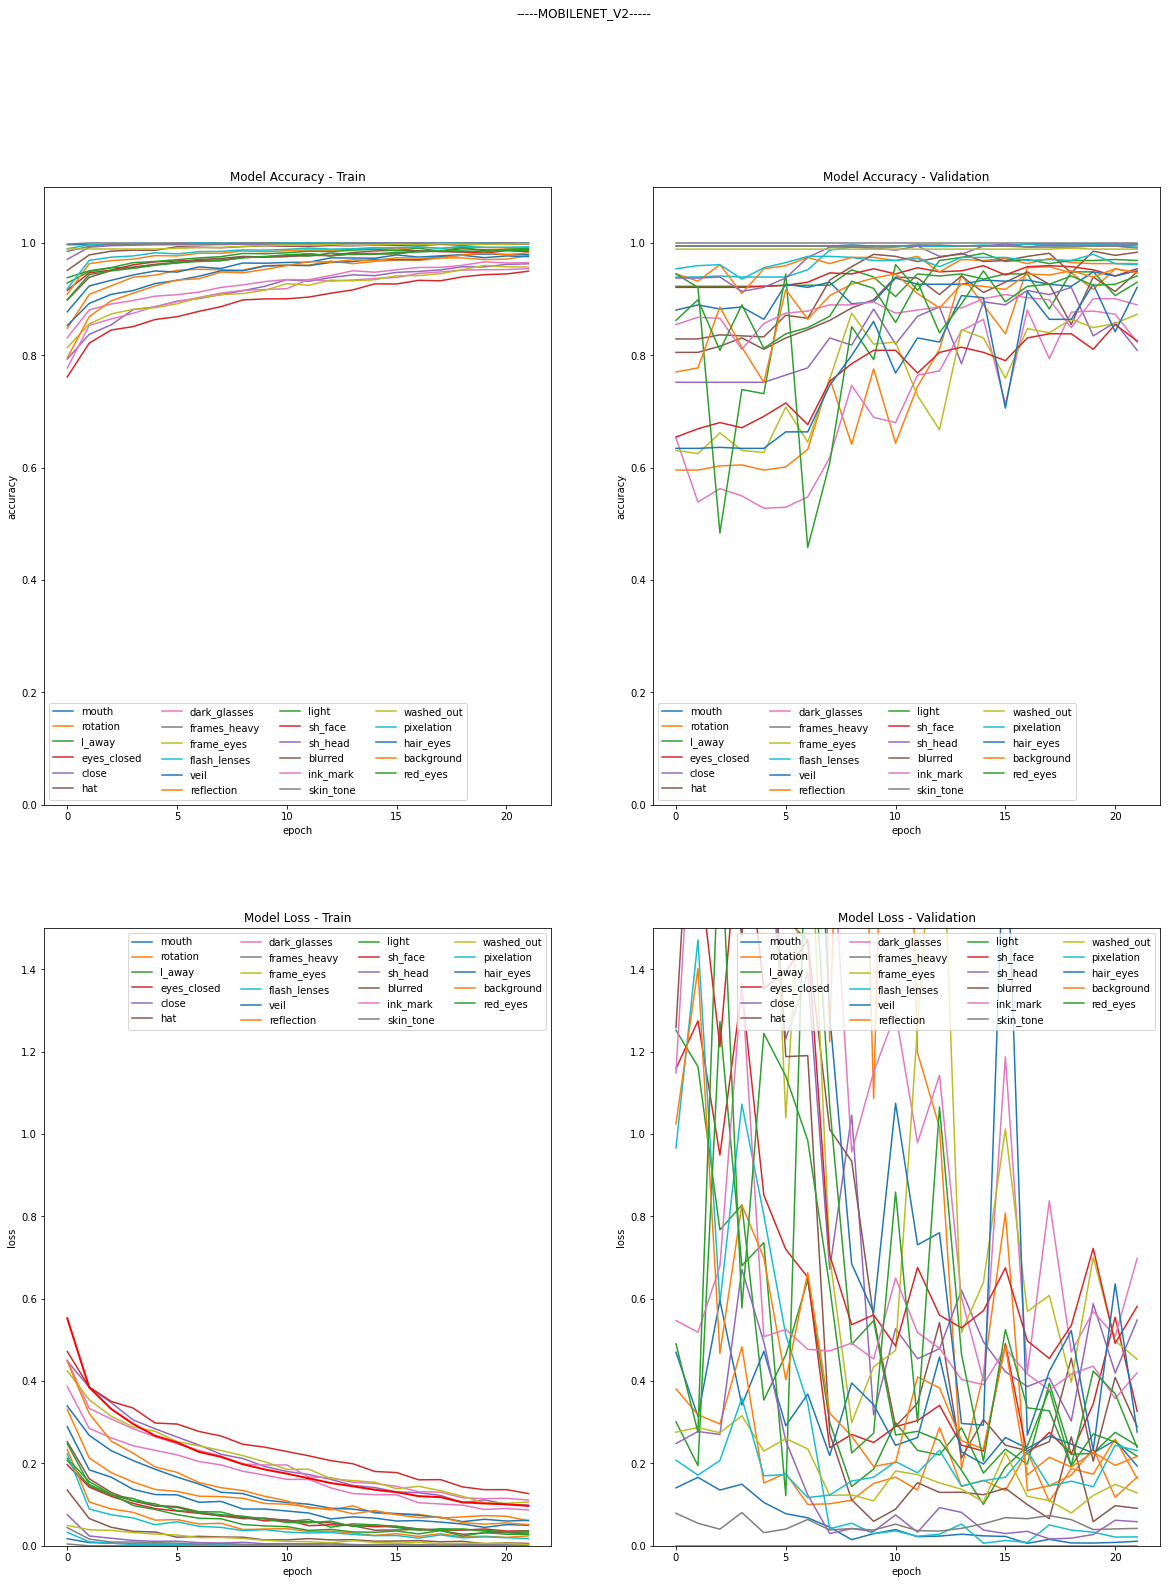

In [14]:
runner.draw_training_history()

# Load Best Model

In [15]:
runner.load_best_model()

-------------------- load best model -------------------
..Loading best model
..Checkpoint weights loaded


# Saving Trained Model

In [16]:
runner.save_model()

-------------------- save model -------------------
Saving model


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: trained_model/assets
..Model saved
...Model path: trained_model
Saving model to neptune
 ..Uploading file trained_model.zip
Model saved into Neptune
Saving process finished


# Test Trained Model

## Validation Split

In [17]:
runner.set_model_evaluator_data_src(DataSource.VALIDATION)
runner.test_model(verbose=False)

Testing Trained Model
Predicting labels....
18/18 [==============================] - 33s 2s/step
Prediction finished!


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


  Task  0: mouth           | EER_mean: 0.07870 | EER_interp: 0.08100 | ACC: 0.91770
  Task  1: rotation        | EER_mean: 0.16060 | EER_interp: 0.15960 | ACC: 0.84100
  Task  2: l_away          | EER_mean: 0.15760 | EER_interp: 0.16120 | ACC: 0.83730
  Task  3: eyes_closed     | EER_mean: 0.04760 | EER_interp: 0.04740 | ACC: 0.95250
  Task  4: close           | EER_mean: 0.15510 | EER_interp: 0.00000 | ACC: 0.01100
  Task  5: hat             | EER_mean: 0.01540 | EER_interp: 0.01310 | ACC: 0.98540
  Task  6: dark_glasses    | EER_mean: 0.01210 | EER_interp: 0.00000 | ACC: 0.98900
  Task  7: frames_heavy    | EER_mean: 0.00000 | EER_interp: 0.00000 | ACC: 0.99450
  Task  8: frame_eyes      | EER_mean: 0.06580 | EER_interp: 0.06580 | ACC: 0.93420
  Task  9: flash_lenses    | EER_mean: 0.06220 | EER_interp: 0.06200 | ACC: 0.93780
  Task 10: veil            | EER_mean: 0.00780 | EER_interp: 0.00000 | ACC: 0.99270
  Task 11: reflection      | EER_mean: 0.11700 | EER_interp: 0.11510 | ACC: 

## Test Split

In [18]:
runner.set_model_evaluator_data_src(DataSource.TEST)
runner.test_model(verbose=False)

Testing Trained Model
Predicting labels....
9/9 [==============================] - 23s 3s/step
Prediction finished!
  Task  0: mouth           | EER_mean: 0.12330 | EER_interp: 0.13140 | ACC: 0.86460
  Task  1: rotation        | EER_mean: 0.12500 | EER_interp: 0.13220 | ACC: 0.86460
  Task  2: l_away          | EER_mean: 0.16420 | EER_interp: 0.16260 | ACC: 0.83680
  Task  3: eyes_closed     | EER_mean: 0.03000 | EER_interp: 0.02410 | ACC: 0.97220
  Task  4: close           | EER_mean: 0.04550 | EER_interp: 0.00000 | ACC: 0.95490
  Task  5: hat             | EER_mean: 0.01960 | EER_interp: 0.01400 | ACC: 0.98960
  Task  6: dark_glasses    | EER_mean: 0.02780 | EER_interp: 0.00000 | ACC: 0.97220
  Task  7: frames_heavy    | EER_mean: 0.00000 | EER_interp: 0.00000 | ACC: 0.99310
  Task  8: frame_eyes      | EER_mean: 0.08330 | EER_interp: 0.07840 | ACC: 0.92360
  Task  9: flash_lenses    | EER_mean: 0.06670 | EER_interp: 0.05960 | ACC: 0.94440
  Task 10: veil            | EER_mean: 0.047

# Visualize Model Classification

# Finishing Experiment Manager

In [19]:
runner.finish_experiment()

-------------------- finish experiment -------------------
Finishing Neptune
Shutting down background jobs, please wait a moment...
Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: RequestsFutureAdapterTimeout
Done!
Waiting for the remaining 2820 operations to synchronize with Neptune. Do not kill this process.
Still waiting for the remaining 2820 operations (0.00% done). Please wait.
Still waiting for the remaining 2820 operations (0.00% done). Please wait.
Still waiting for the remaining 2820 operations (0.00% done). Please wait.
Still waiting for the remaining 2820 operations (0.00% done). Please wait.
Still waiting for the remaining 2820 operations (0.00% done). Please wait.
Still waiting for the remaining 2820 operations (0.00% done). Please wait.
Still waiting for the remaining 2820 operations (0.00% done). Please wait.
Still waiting for the remaining 2820 operations (0.00% done). Please wait.
Still waiting for the

Error occurred during asynchronous operation processing: Value of float attribute cannot be malformed.
Error occurred during asynchronous operation processing: Value of float attribute cannot be malformed.
Error occurred during asynchronous operation processing: Value of float attribute cannot be malformed.
Error occurred during asynchronous operation processing: Value of float attribute cannot be malformed.


All 2820 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/guilhermemg/icao-nets-training-2/e/ICAO-344


# Testing Network Modification

# Test - Customized Loss Function

# Test - 